<a href="https://colab.research.google.com/github/CorleoneAppolonia/PMP-2024/blob/main/Lab%2012/tema.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az


In [52]:
!pip install pymc arviz --quiet

import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# Datele observate
x = np.array([1, 3, 4, 5, 6, 8])
y = np.array([0, 0, 1, 1, 1, 1])

# Definim modelul Bayesian de regresie logistică
# Model: p = logistic(alpha + beta * x)
with pm.Model() as model:
    # Priori pentru intercept (alpha) si panta (beta)
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10)

    # Definim parametrul logistic
    p = pm.Deterministic("p", pm.math.sigmoid(alpha + beta * x))

    # Verosimilitatea
    y_obs = pm.Bernoulli("y_obs", p=p, observed=y)

    # Eșantionare cu NUTS sau alt sampler MCMC
    trace = pm.sample(2000, tune=1000, target_accept=0.9, random_seed=42)

# Rezumatul inferenței
az.summary(trace, var_names=["alpha","beta"])


Output()

Output()

ERROR:pymc.stats.convergence:There were 323 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-11.480,6.065,-22.298,-1.166,0.299,0.258,450.0,237.0,1.01
beta,3.447,1.688,0.574,6.607,0.080,0.066,457.0,239.0,1.01


In [ ]:
# Extragem eșantioanele posterioare
alpha_samples = trace.posterior["alpha"].values.flatten()
beta_samples = trace.posterior["beta"].values.flatten()

# Calculăm frontiera de decizie pentru fiecare eșantion
x_frontier_samples = -alpha_samples / beta_samples

# Calculăm intervale de credibilitate (HDI) pentru frontiera de decizie
hdi_frontier = az.hdi(x_frontier_samples, hdi_prob=0.95)
median_frontier = np.median(x_frontier_samples)

print("Frontiera de decizie mediană:", median_frontier)
print("95% HDI pentru frontiera de decizie:", hdi_frontier)


Frontiera de decizie mediană: 3.316688005949398
95% HDI pentru frontiera de decizie: [1.88850663 4.75742968]


<ipython-input-6-e4254ca1b4e9>:12: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  p_hdi = az.hdi(p_samples, hdi_prob=0.95)


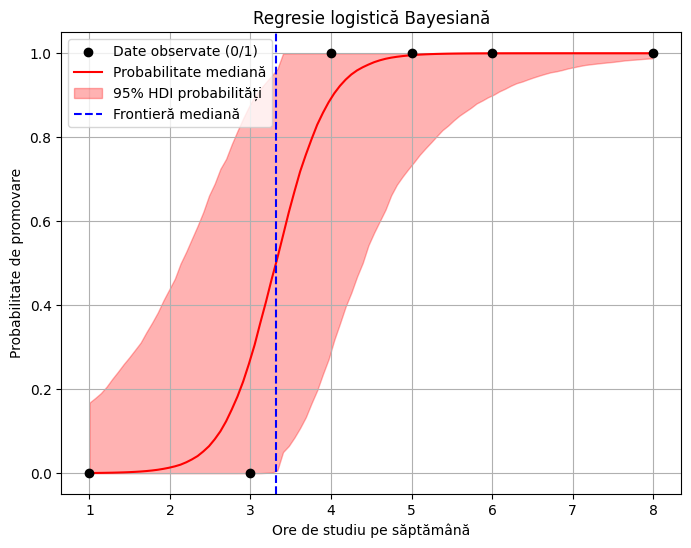

In [ ]:
# Construim un grid de valori x pentru a vedea curba logistică
x_grid = np.linspace(min(x), max(x), 100)
p_samples = []

for alpha_s, beta_s in zip(alpha_samples, beta_samples):
    p_samples.append(1 / (1 + np.exp(-(alpha_s + beta_s * x_grid))))

p_samples = np.array(p_samples)  # shape: (n_samples, len(x_grid))

# Calculăm mediană și HDI pentru fiecare x din grid
p_median = np.median(p_samples, axis=0)
p_hdi = az.hdi(p_samples, hdi_prob=0.95)

# Afișarea rezultatelor
plt.figure(figsize=(8,6))
# Punctele observate
plt.scatter(x, y, color='black', zorder=10, label="Date observate (0/1)")

# Curba mediană
plt.plot(x_grid, p_median, color='red', label="Probabilitate mediană")

# Bandă de incertitudine
plt.fill_between(x_grid, p_hdi[:,0], p_hdi[:,1], alpha=0.3, color='red', label="95% HDI probabilități")

# Linie verticală la frontiera mediană
plt.axvline(median_frontier, color='blue', linestyle='--', label='Frontieră mediană')

plt.xlabel("Ore de studiu pe săptămână")
plt.ylabel("Probabilitate de promovare")
plt.title("Regresie logistică Bayesiană")
plt.legend()
plt.grid(True)
plt.show()


Problema 2)

a) Folosind distribuţii a priori slab informative asupra parametrilor β0, β1 şi β2, folosiţi PyMC pentru a
simula un eşantion suficient de mare (construi modelul) din distribuţia a posteriori.

In [44]:
!pip install pymc arviz --quiet

import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# Citim datele
data = pd.read_csv("Admission.csv", sep=",")  # Dacă separatorul este virgulă
GRE = data['GRE'].values
GPA = data['GPA'].values
y = data['Admission'].values # This is the change - extracting the correct y values


data['GRE'] = (data['GRE'] - data['GRE'].mean()) / data['GRE'].std()
data['GPA'] = (data['GPA'] - data['GPA'].mean()) / data['GPA'].std()


# Standardizarea predictorilor (opțional, dar poate ajuta la convergență)
# Aici putem decide sa standardizăm sau doar să centram
GRE_mean, GRE_std = GRE.mean(), GRE.std()
GPA_mean, GPA_std = GPA.mean(), GPA.std()

GRE_s = (GRE - GRE_mean)/GRE_std
GPA_s = (GPA - GPA_mean)/GPA_std

with pm.Model() as model:
    # Priori slab informative
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta_GRE = pm.Normal("beta_GRE", mu=0, sigma=10)
    beta_GPA = pm.Normal("beta_GPA", mu=0, sigma=10)

    # Modelul liniar
    mu = alpha + beta_GRE * GRE_s + beta_GPA * GPA_s
    p = pm.Deterministic("p", pm.math.sigmoid(mu))

    # Verosimilitate
    y_obs = pm.Bernoulli("y_obs", p=p, observed=y)

    # Eșantionare
    trace = pm.sample(2000, tune=1000, target_accept=0.9, random_seed=42)
    idata = trace

# Rezumat parametri
print(az.summary(idata, var_names=["alpha","beta_GRE","beta_GPA"]))


Output()

Output()

           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha    -0.815  0.111  -1.031   -0.616      0.002    0.001    3159.0   
beta_GRE  0.312  0.123   0.093    0.544      0.002    0.002    3275.0   
beta_GPA  0.288  0.120   0.054    0.510      0.002    0.002    2895.0   

          ess_tail  r_hat  
alpha       2706.0    1.0  
beta_GRE    2902.0    1.0  
beta_GPA    2741.0    1.0  


<ipython-input-45-2e6e11153a87>:27: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  frontier_hdi = az.hdi(frontiers, hdi_prob=0.94)


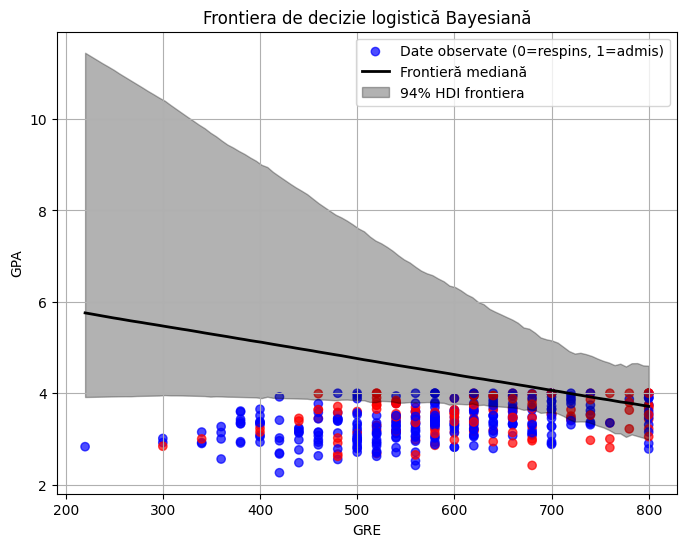

In [45]:

# (b) Granita de decizie
# frontiera de decizie este dată de p=0.5 => mu=0 => alpha + beta_GRE*GRE_s + beta_GPA*GPA_s =0
# Pentru a trasa frontiera, alegem un grid de GRE, apoi rezolvăm pentru GPA:
# GPA_s = -(alpha + beta_GRE*GRE_s)/beta_GPA
# GPA = GPA_s*GPA_std + GPA_mean

# Extragem eșantioane posterioare
alpha_samples = idata.posterior["alpha"].values.flatten()
betaGRE_samples = idata.posterior["beta_GRE"].values.flatten()
betaGPA_samples = idata.posterior["beta_GPA"].values.flatten()

GRE_grid = np.linspace(GRE.min(), GRE.max(), 100)
GRE_s_grid = (GRE_grid - GRE_mean)/GRE_std

# pentru fiecare eșantion calculăm frontiera:
# GPA_s = -(alpha+beta_GRE*GRE_s)/beta_GPA
# GPA = GPA_s*GPA_std + GPA_mean

frontiers = []
for a,bg,bp in zip(alpha_samples, betaGRE_samples, betaGPA_samples):
    frontier_GPA = -(a+bg*GRE_s_grid)/bp
    frontier_GPA_real = frontier_GPA*GPA_std + GPA_mean
    frontiers.append(frontier_GPA_real)
frontiers = np.array(frontiers)

frontier_median = np.median(frontiers, axis=0)
frontier_hdi = az.hdi(frontiers, hdi_prob=0.94)

# Plotam datele și frontiera de decizie
plt.figure(figsize=(8,6))
# Colorăm punctele în funcție de clasă
plt.scatter(GRE, GPA, c=y, cmap="bwr", alpha=0.7, label="Date observate (0=respins, 1=admis)")
plt.plot(GRE_grid, frontier_median, color='k', lw=2, label="Frontieră mediană")
plt.fill_between(GRE_grid, frontier_hdi[:,0], frontier_hdi[:,1], color='k', alpha=0.3, label="94% HDI frontiera")

plt.xlabel("GRE")
plt.ylabel("GPA")
plt.title("Frontiera de decizie logistică Bayesiană")
plt.legend()
plt.grid(True)
plt.show()


In [50]:

# (c) Probabilitatea pentru un student cu GRE=550, GPA=3.5
GRE_new = 550
GPA_new = 3.5
GRE_new_s = (GRE_new - GRE_mean)/GRE_std
GPA_new_s = (GPA_new - GPA_mean)/GPA_std

p_new_samples = 1/(1+np.exp(-(alpha_samples + betaGRE_samples*GRE_new_s + betaGPA_samples*GPA_new_s)))
p_new_median = np.median(p_new_samples)
p_new_hdi = az.hdi(p_new_samples, hdi_prob=0.90)

print(f"Student 1: GRE=550, GPA=3.5 => Probabilitate mediană de admitere: {p_new_median:.2f}")
print(f"Intervalul HDI de 90%: {p_new_hdi}")


Student 1: GRE=550, GPA=3.5 => Probabilitate mediană de admitere: 0.30
Intervalul HDI de 90%: [0.25813915 0.3477352 ]


In [51]:

# (d) Pentru GRE=500, GPA=3.2
GRE_new2 = 500
GPA_new2 = 3.2
GRE_new2_s = (GRE_new2 - GRE_mean)/GRE_std
GPA_new2_s = (GPA_new2 - GPA_mean)/GPA_std

p_new2_samples = 1/(1+np.exp(-(alpha_samples + betaGRE_samples*GRE_new2_s + betaGPA_samples*GPA_new2_s)))
p_new2_median = np.median(p_new2_samples)
p_new2_hdi = az.hdi(p_new2_samples, hdi_prob=0.90)

print(f"Student 2: GRE=500, GPA=3.2 => Probabilitate mediană de admitere: {p_new2_median:.2f}")
print(f"Intervalul HDI de 90%: {p_new2_hdi}")

# Comparație:
# Observăm cum diferă intervalele și medianele probabilităților de admitere între cei doi studenți.


Student 2: GRE=500, GPA=3.2 => Probabilitate mediană de admitere: 0.23
Intervalul HDI de 90%: [0.19044753 0.27915999]


Diferența probabilităților dintre punctele c) și d) rezultă din relația liniară dintre predictorii standardizați și probabilitatea logistică. Scăderea atât a GRE (de la 550 la 500) cât și a GPA (de la 3.5 la 3.2) determină o reducere cumulativă a probabilității de admitere, accentuată de importanța relativă mai mare a GRE în acest model.

Incertitudinea modelului (reflectată de HDI) confirmă această concluzie: studentul din punctul d) are șanse semnificativ mai mici de admitere decât studentul din punctul c), într-un mod consistent cu coeficienții estimați de regresia logistică Bayesiană.






